# Wave 2D linear solver

adapted from Paker repo

In [ ]:
# | default_exp solver.wave2d_modal

In [ ]:
# | export

import numpy as np
import jax.numpy as jnp
import jax

In [ ]:
# | export

class WaveSolver2DJax:
    def __init__(
        self,
        sampling_rate: int = 48000,  # 1/s     Temporal sampling frequency
        final_time: float = 0.02,  # s       Duration of the simulation
        rho: float = 1.2041,  # kg/m**3 Density
        n_max_modes: int = 10,  #         Number of modal expansion terms
        lx: float = 1.0,  # m       Length in x direction
        ly: float = 1.0,  # m       Length in y direction
        c0: float = 343,  # m/s     Speed of sound
        damping=1.0,  #         Damping factor
        spatial_delta=1e-3,  # m       Spatial sampling grid
    ):
        T = 1 / sampling_rate

        self.numT = round(final_time / T)
        self.t = np.linspace(0, final_time, num=self.numT, endpoint=True)  # time vector

        self.numXs = round(lx / spatial_delta)
        self.numYs = round(ly / spatial_delta)
        xs = np.linspace(0, lx, num=self.numXs, endpoint=True)  # space vector
        ys = np.linspace(0, ly, num=self.numYs, endpoint=True)  # space vector

        xv, yv = np.meshgrid(np.arange(n_max_modes), np.arange(n_max_modes))
        mux = xv.flatten() + 1
        muy = yv.flatten() + 1

        mu = np.arange(n_max_modes * n_max_modes)

        lamX = mux * np.pi / lx
        lamY = muy * np.pi / ly

        smu = 1j * c0 * np.sqrt(lamX[mu] ** 2 + lamY[mu] ** 2)

        smu = np.hstack((smu, np.conj(smu)))
        lamX = np.hstack((lamX.T, lamX.T))
        lamY = np.hstack((lamY.T, lamY.T))

        # add damping
        smu = smu - damping

        ## FTM - scaling factor
        nx = -8 * lamX**2 / (rho * smu**2) * lx * ly
        ny = -8 * lamY**2 / (rho * smu**2) * lx * ly
        nc = 8 / (rho * c0**2) * lx * ly

        nmu = nx + ny + nc

        ## FTM - Eigenfunctions
        self.K1 = lambda x, y: 4 * np.cos(lamX * x) * np.cos(lamY * y)
        self.K2 = (
            lambda x, y: 4 * lamX / (smu * rho) * np.sin(lamX * x) * np.cos(lamY * y)
        )
        self.K3 = (
            lambda x, y: 4 * lamY / (smu * rho) * np.cos(lamX * x) * np.sin(lamY * y)
        )

        self.Ka1 = (
            lambda x, y: -4 * lamX / (smu * rho) * np.sin(lamX * x) * np.cos(lamY * y)
        )
        self.Ka2 = (
            lambda x, y: -4 * lamY / (smu * rho) * np.cos(lamX * x) * np.sin(lamY * y)
        )
        self.Ka3 = lambda x, y: 4 * np.cos(lamX * x) * np.cos(lamY * y)

        K1_sp = np.zeros(
            (xs.size, ys.size, nmu.size), dtype=complex
        )  # Eigenfunctions for sound pressure
        K2_vx = np.zeros(
            (xs.size, ys.size, nmu.size), dtype=complex
        )  # Eigenfunctions for particle velocity in x-direction
        K3_vy = np.zeros(
            (xs.size, ys.size, nmu.size), dtype=complex
        )  # Eigenfunctions for particle velocity in y-direction

        for xi in range(xs.size):
            for yi in range(ys.size):
                K1_sp[xi, yi, :] = self.K1(xs[xi], ys[yi]) / nmu
                K2_vx[xi, yi, :] = self.K2(xs[xi], ys[yi]) / nmu
                K3_vy[xi, yi, :] = self.K3(xs[xi], ys[yi]) / nmu

        # Explicity copy variables
        self.lx = lx
        self.ly = ly
        self.smu = smu
        self.nmu = nmu
        self.T = T
        self.Fs = sampling_rate
        self.xs = xs
        self.ys = ys
        self.K1_sp = K1_sp
        self.K2_vx = K2_vx
        self.K3_vy = K3_vy

        self.lamX = lamX
        self.lamY = lamY

    def create_impulse(self, xe_rel, ye_rel):
        # Explicity copy variables
        lx, ly = self.lx, self.ly

        # Use a delta at exciation position on the string
        xe = xe_rel * lx
        ye = ye_rel * ly

        # impulse excitation at (xe,ye)
        fe_xy = self.Ka3(xe, ye)

        return fe_xy

    def create_random_initial(
        self,
        rng: np.random.Generator = np.random.default_rng(),
    ) -> np.ndarray:
        # Explicity copy variables
        lx, ly = self.lx, self.ly
        xs, ys = self.xs, self.ys
        smu = self.smu
        lamX, lamY = self.lamX, self.lamY

        fe_xy = np.zeros((1, smu.size))

        rx = rng.uniform(-1, 1, (smu.size, xs.size))  # Shape: (smu.size, xs.size)
        ry = rng.uniform(-1, 1, (smu.size, ys.size))  # Shape: (smu.size, ys.size)
        funX = 4 * np.cos(lamX[:, None] * xs) * rx  # Broadcasting lamX and rx
        funY = np.cos(lamY[:, None] * ys) * ry  # Broadcasting lamY and ry
        integX = np.trapz(funX, xs, axis=-1)  # Shape: (smu.size,)
        integY = np.trapz(funY, ys, axis=-1)  # Shape: (smu.size,)
        fe_xy = integX[:, np.newaxis] * integY  # Shape: (smu.size, smu.size)
        fe_xy = integX * integY

        return fe_xy

    def solve(
        self,
        u0,
        v0=None,
        parallel=True,
    ):
        ## Copy internal variables
        T = self.T
        smu = self.smu

        ## Simulation - state equation

        if parallel:
            # ybar = jnp.vander(jnp.exp(smu * T), self.t.size, increasing=True)
            # ybar = ybar * fe_x[:, None]
            # ybar = jnp.cumprod(jnp.exp(smu * T), axis=0)
            # print(ybar.shape)
            smu = jnp.repeat(smu[None, :], self.t.size - 1, axis=0)
            ybar = jax.lax.associative_scan(jnp.multiply, jnp.exp(smu * T)) * u0
            ybar = ybar.T
            ybar = jnp.concatenate((u0[..., None], ybar), axis=1)
        else:
            ybar = np.zeros((smu.size, self.t.size), dtype=complex)
            ybar[:, 0] = u0
            for k in range(1, self.t.size):  # for k = 2:length(t)
                ybar[:, k] = np.exp(smu * T) * ybar[:, k - 1]

        # project back to spatial domain
        y_sp = self.K1_sp @ ybar
        y_vx = self.K2_vx @ ybar
        y_vy = self.K3_vy @ ybar

        # y    = np.float32(np.real(y))
        ybar = jnp.real(ybar).astype(jnp.float32)
        y_sp = jnp.real(y_sp).astype(jnp.float32)
        y_vx = jnp.real(y_vx).astype(jnp.float32)
        y_vy = jnp.real(y_vy).astype(jnp.float32)

        return ybar, y_sp, y_vx, y_vy

In [ ]:
# | eval: false
# jax.config.update("jax_enable_x64", False)
# os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true" # add xla flags

dur = 0.001
num_variations = 1024

fs = 48000
num_points = 40
simulated_modes = 25
room_size = 1
room_aspect_ratio = 1
num_example_timesteps = 100

#######################################################################################################################
solver = WaveSolver2DJax(
    final_time=dur,
    sampling_rate=fs,
    lx=room_size,
    ly=room_aspect_ratio * room_size,
    spatial_delta=room_size / num_points,
    n_max_modes=simulated_modes,
)

In [ ]:
# | eval: false

# jax.config.update("jax_enable_x64", False)

fe_x = solver.create_random_initial(np.random.default_rng(42))
# fe_x = solver.create_impulse(0.5, 0.5)

ybar, y_sp, y_vx, y_vy = solver.solve(fe_x)
ybar_vander, y_sp_vander, y_vx_vander, y_vy_vander = solver.solve(fe_x, parallel=True)

diff_ybar = np.abs(ybar - ybar_vander)
diff_y_sp = np.abs(y_sp - y_sp_vander)
diff_y_vx = np.abs(y_vx - y_vx_vander)
diff_y_vy = np.abs(y_vy - y_vy_vander)

print("ybar diff", np.max(diff_ybar))
print("y_sp diff", np.max(diff_y_sp))
print("y_vx diff", np.max(diff_y_vx))
print("y_vy diff", np.max(diff_y_vy))


ybar diff 0.0
y_sp diff 0.0
y_vx diff 0.0
y_vy diff 0.0


(40, 40, 48) (40, 40, 48) (40, 40, 48)


<matplotlib.image.AxesImage>

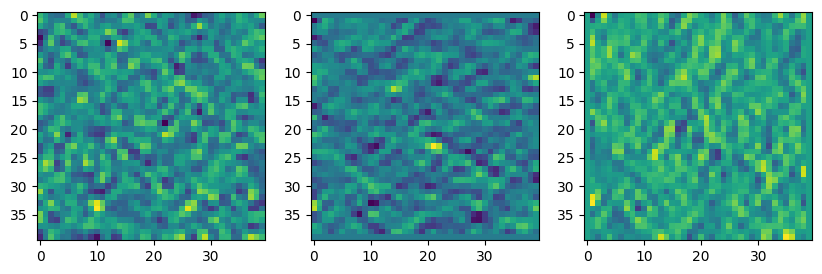

In [ ]:
# | eval: false


print(y_sp.shape, y_vx.shape, y_vy.shape)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(y_sp[:,:,200])
ax[1].imshow(y_vx[:,:,200])
ax[2].imshow(y_vy[:,:,200])

### Save a fast dataset

In [ ]:
# | export

from einops import rearrange
from pathlib import Path
from fastcore.script import call_parse
from tqdm import tqdm

In [ ]:
# | export
@call_parse
def create_2d_wave_data(
    num_ics: int,  # number of initial conditions
    data_dir: str,  # directory to save the data
    W: int = 40,  # width
    dur: float = 0.01,  # time
    sample_rate: int = 48000,  # sampling rate
    simulated_modes: int = 25,  # number of modes
    seed: int = 42,  # random seed
    ic_type: str = "random",  # type of initial condition (random or impulse)
):
    # set the global precision to 64-bit
    jax.config.update("jax_enable_x64", True)

    H = W
    room_size = 1
    room_aspect_ratio = 1
    sampling_period = 1 / sample_rate
    T = round(dur / sampling_period)

    solver = WaveSolver2DJax(
        final_time=dur,
        sampling_rate=sample_rate,
        lx=room_size,
        ly=room_aspect_ratio * room_size,
        spatial_delta=room_size / W,
        n_max_modes=simulated_modes,
    )

    # approximate Gb
    total_size_bytes = num_ics * T * H * W * 3 * 4
    print("Total size in GB", total_size_bytes / 1e9)

    # make sure the data directory exists
    Path(data_dir).mkdir(parents=True, exist_ok=True)

    # seed the random number generator
    rng = np.random.default_rng(seed)
    for i in tqdm(range(1, num_ics + 1)):

        u0 = (
            solver.create_impulse(rng.uniform(), rng.uniform())
            if ic_type == "impulse"
            else solver.create_random_initial(rng)
        )

        ybar, y_sp, y_vx, y_vy = solver.solve(u0)
        run_2d = jnp.stack((y_sp, y_vx, y_vy), axis=-1)
        run_2d = rearrange(run_2d, "h w t c -> t h w c")
        jnp.save(f"{data_dir}/ic_{i:05d}.npy", run_2d)

In [ ]:
# | eval: false

data_dir = "2d_wave_data"

create_2d_wave_data(1000, data_dir, ic_type="random")

Total size in GB 0.000192


100%|██████████| 1000/1000 [01:30<00:00, 11.01it/s]


In [ ]:
# | eval: false

import matplotlib.pyplot as plt

(480, 40, 40, 3)
(480, 40, 40, 3)
(480, 40, 40, 3)


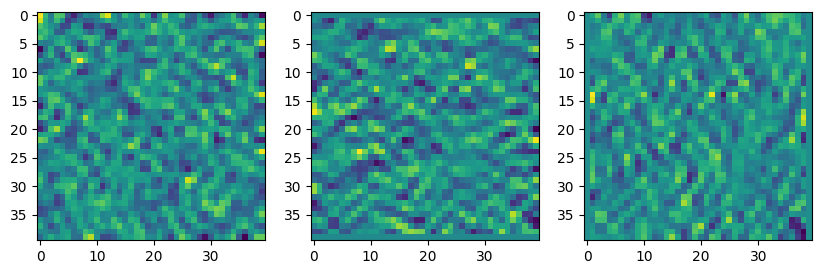

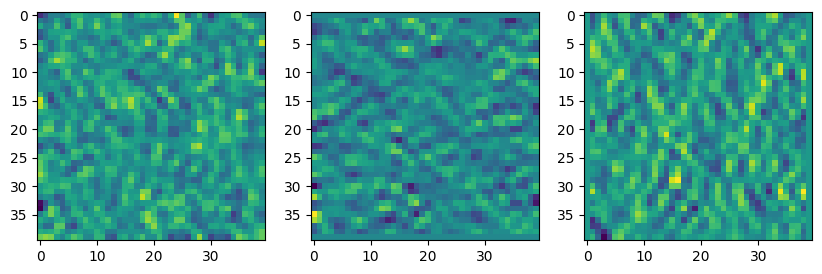

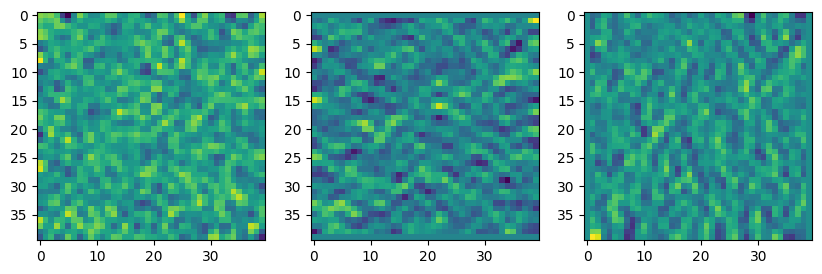

In [ ]:
# | eval: false

# check the data, the first 3 files should be different
for i in range(1, 4):
    data = np.load(f"{data_dir}/ic_{i:05d}.npy")
    print(data.shape)
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(data[100, :, :, 0])
    ax[1].imshow(data[100, :, :, 1])
    ax[2].imshow(data[100, :, :, 2])

plt.show()